# **Packages**

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# **Neural Network Architecture**

In [255]:
# Define the NeuralNetwork class
class NeuralNetwork:
    layers = []
    masks = []
    layer_sizes = 0
    def create_hidden_network(self,layer_sizes):
      self.num_layers = len(layer_sizes)

    # ساختن لایه های پنهان
      for i in range(1, self.num_layers):
        input_size = layer_sizes[i - 1]
        output_size = layer_sizes[i]
        hidden_layer = {
            'weights': np.random.randn(input_size, output_size),
            'biases': np.random.randn(1,output_size)
        }
        self.layers.append(hidden_layer)

    def __init__(self, layer_sizes):
        self.layer_sizes=layer_sizes
        input_layer = {
            'weights': np.random.randn(4, layer_sizes[0]),
            'biases': np.zeros((1,layer_sizes[0]))
        }
        self.layers.append(input_layer)
        self.create_hidden_network(layer_sizes)
        output_layer = {
            'weights': np.random.randn(layer_sizes[len(layer_sizes)-1], 3),
            'biases': np.zeros((1,3))
        }
        self.layers.append(output_layer)
        for i,layer in enumerate(self.layers):
          if((i!=0)and(i<(len(self.layers)-1))):
            msk = np.array(self.Make_Mask(layer),dtype=np.float64)
            layer['weights'] = np.multiply(msk,layer['weights'])
            self.masks.append(msk)
        #print(self.layers)
    def forward_pass(self, X):
        self.results = []
        z=np.dot(X,self.layers[0]['weights']) + self.layers[0]['biases']
        input_pass ={'z':z ,'a':self.relu(z)}
        self.results.append(input_pass)
        for i,layer in enumerate(self.layers):
          if(i+2<len(self.layers)):
            z=(np.dot((self.results[i]['a']),self.layers[i+1]['weights'])) + (self.layers[i+1]['biases'])
            a=self.relu(z)
            input_pass ={'z':z ,'a':a}
            self.results.append(input_pass)
          else:
            z=(np.dot((self.results[i]['a']),(self.layers[i+1]['weights']))) + (self.layers[i+1]['biases'])
            a = self.softmax(z)
            input_pass ={'z':z ,'a':a}
            self.results.append(input_pass)
            return a

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self,z):
      eps=1e-10
      z_shifted = z + eps
      exp_z = np.exp(z_shifted - np.max(z_shifted, axis=1, keepdims=True))
      softmax_z = exp_z / np.sum(exp_z, axis=1, keepdims=True)
      return softmax_z

    def backward_pass(self, X, y, learning_rate):
        m = X.shape[0]
        self.deltas = []
        delta_a = 0
        delta_z = (self.results[(len(self.layers)-1)]['a']) - y
      # delta_W = (1 / m) * np.dot(self.a1.T, delta_z2)
        delta_W = (1 / m) * np.dot(self.results[len(self.layers)-2]['a'].T, delta_z)
        delta_b = (1 / m) * np.sum(delta_z, axis=0, keepdims=True)
        back = {'delta_a':delta_a,'delta_z':delta_z,'delta_W':delta_W,'delta_b':delta_b}
        self.deltas.append(back)
        for i,layer in enumerate(self.layers):
        # delta_a1 = np.dot(delta_z2, self.W2.T)
          delta_a1 = np.dot(self.deltas[i]['delta_z'], self.layers[len(self.layers)-i-1]['weights'].T)
        # delta_z1 = delta_a1 * self.relu_derivative(self.z1)
          delta_z1 = delta_a1 * self.relu_derivative(self.results[len(self.layers)-i-2]['z'])
        # delta_b1 = (1 / m) * np.sum(delta_z1, axis=0, keepdims=True)
          delta_b1 = (1 / m) * np.sum(delta_z1, axis=0, keepdims=True)

          if((len(self.layers))-i-2==0):
            delta_W1 = (1 / m) * np.dot(X.T, delta_z1)
            back = {'delta_a':delta_a1,'delta_z':delta_z1,'delta_W':delta_W1,'delta_b':delta_b1}
            self.deltas.append(back)
            break
          else:
          # delta_W1 = (1 / m) * np.dot(X.T, delta_z1)
            delta_W1 = (1 / m) * np.dot(self.results[len(self.layers)-i-3]['a'].T, delta_z1)
            back = {'delta_a':delta_a1,'delta_z':delta_z1,'delta_W':delta_W1,'delta_b':delta_b1}
            self.deltas.append(back)

        for i,layer in enumerate(self.layers):
          if((i!=0)and(i<(len(self.layers)-1))):
            self.layers[len(self.layers)-i-1]['weights'] -=   (learning_rate * self.deltas[i]['delta_W'])
            self.layers[((len(self.layers))-i-1)]['biases'] -= (learning_rate * self.deltas[i]['delta_b'])
            self.layers[len(self.layers)-i-1]['weights'] = np.multiply(self.masks[len(self.layers)-i-2],(self.layers[len(self.layers)-i-1]['weights']))
          else:
            self.layers[len(self.layers)-i-1]['weights'] -=   (learning_rate * self.deltas[i]['delta_W'])
            self.layers[((len(self.layers))-i-1)]['biases'] -= (learning_rate * self.deltas[i]['delta_b'])



    def relu_derivative(self, Z):
        return np.where(Z <= 0, 0, 1)

    def cross_entropy_loss(self,y_true, y_pred):
      epsilon = 1e-10  # small value to prevent division by zero
      num_samples = y_true.shape[0]
      loss = -np.sum(y_true * np.log(y_pred + epsilon)) / num_samples

      return loss
    def Make_Mask(self,layer):
        neurons_count = layer['weights'].shape[0]
        next_neurons_count =  layer['weights'].shape[1]
        mask =[]
        for i in range(neurons_count):
          neuron_weights = []
          flag1=0.0
          flag2=1.0
          if(i%2==0):
            for j in range(next_neurons_count):
              neuron_weights.append(int(flag1))
              flag1= not flag1
          else:
            for j in range(next_neurons_count):
              neuron_weights.append(int(flag2))
              flag2=not flag2
          flag1=0.0
          flag2=1.0
          mask.append(neuron_weights)
        return mask

    def train(self, t_X, t_y,v_X,v_y,y_test,y_validation, num_epochs, learning_rate):
        train_loss = []
        validation_loss = []
        train_accuracy = []
        validation_accuracy = []
        for epoch in range(num_epochs):
           out = self.forward_pass(t_X)
           t_loss=self.cross_entropy_loss(t_y,out)
           train_loss.append(t_loss)
           self.backward_pass(t_X, t_y, learning_rate)
           out2 = self.forward_pass(v_X)
           v_loss=self.cross_entropy_loss(v_y,out2)
           validation_loss.append(v_loss)

           y_pred_acc = self.predict(v_X)
           v_accuracy = np.mean(y_pred_acc == y_validation)*100
           y_pred_train = self.predict(t_X)
           train_acc = np.mean(y_pred_train == y_test)*100

           train_accuracy.append(train_acc)
           validation_accuracy.append(v_accuracy)
           if num_epochs < 10:
                print(f'EPOCH :{epoch} Train loss :{t_loss:.4f} ------------------- Validation loss : {v_loss:.4f}')
           else:
                if epoch % 10 == 0:
                  print(f'EPOCH :{epoch} Train loss :{t_loss:.4f} ------------------- Validation loss : {v_loss:.4f}')

        return train_loss , validation_loss ,train_accuracy,validation_accuracy
    def predict(self, X):
        s = self.forward_pass(X)
        return np.argmax(s, axis=1)

# **Training**

In [256]:
#لطفا برای هر بار اجرای این بخش بخش بالا را نیز از سر ران کنید تا به مشکل نخورید
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Step 1: Splitting the data into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Splitting the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Define the hyperparameters
num_features = X.shape[1]
num_classes = len(np.unique(y))
learning_rate = 0.01
num_epochs = 1000

# خواندن تعداد لایه ها و تعداد نورون ها از کاربر
num_layers = int(input('Number of Layers : '))
layer_sizes = []

for i in range(num_layers):
    layer_size = int(input('Neuronos of Layer{} : '.format(i)))
    layer_sizes.append(layer_size)

model = NeuralNetwork(layer_sizes)
for i, layer in enumerate(model.layers):
    print('Layer{} to Layer{} Weights :{} Biases :{}'.format(i+1,i+2, layer['weights'].shape, layer['biases'].shape))
learning_rate = float(input('Please enter Learning Rate : '))
num_epochs = int(input('Please enter number of epochs : '
))

#print((model.forward_pass(X_train)).shape)
#model.backward_pass(X_train,y_train_encoded,0.01)
# Train the model
train_loss , validation_loss , train_accuracy , validation_accuracy = model.train(X_train, y_train_encoded,X_val,y_val_encoded,y_train,y_val, num_epochs, learning_rate)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)*100
print(f'Test Accuracy: {accuracy:.4f}%')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Number of Layers : 3
Neuronos of Layer0 : 10
Neuronos of Layer1 : 15
Neuronos of Layer2 : 20
Layer1 to Layer2 Weights :(4, 10) Biases :(1, 10)
Layer2 to Layer3 Weights :(10, 15) Biases :(1, 15)
Layer3 to Layer4 Weights :(15, 20) Biases :(1, 20)
Layer4 to Layer5 Weights :(20, 3) Biases :(1, 3)
Please enter Learning Rate : 0.01
Please enter number of epochs : 10000
EPOCH :0 Train loss :15.0897 ------------------- Validation loss : 8.7594
EPOCH :10 Train loss :5.5326 ------------------- Validation loss : 0.3490
EPOCH :20 Train loss :2.8426 ------------------- Validation loss : 3.2385
EPOCH :30 Train loss :0.6077 ------------------- Validation loss : 2.4646
EPOCH :40 Train loss :0.5648 ------------------- Validation loss : 1.5535
EPOCH :50 Train loss :0.1938 ------------------- Validation loss : 0.4469
EPOCH :60 Train loss :0.0695 ------------------- Validation loss : 0.1813
EPOCH :70 Train loss :0.0652 ------------------- Validation loss : 0.1778
EPOCH :80 Train loss :0.0626 -------------

# **Evaluations and Plots**

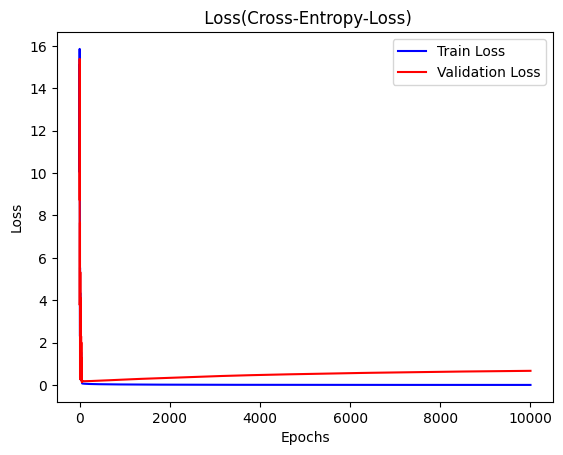

In [257]:
from matplotlib import pyplot as plt
# Create x-axis values (epochs or iterations)
epochs = range(1, len(train_loss) + 1)

# Plot the train loss
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' Loss(Cross-Entropy-Loss)')

# Add legend
plt.legend()

# Show the plot
plt.show()

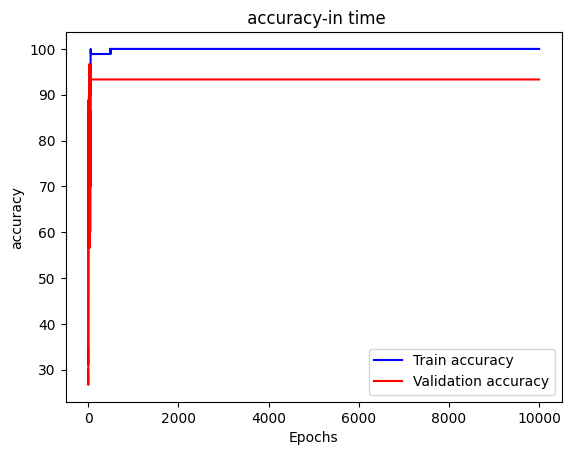

In [258]:
from matplotlib import pyplot as plt
# Create x-axis values (epochs or iterations)
epochs = range(1, len(train_loss) + 1)

# Plot the train loss
plt.plot(epochs, train_accuracy, 'b', label='Train accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title(' accuracy-in time')

# Add legend
plt.legend()

# Show the plot
plt.show()

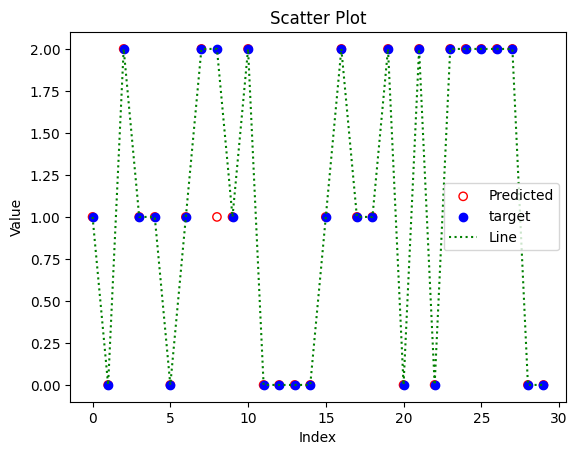

In [259]:
plt.scatter(range(len(y_pred)), y_test,  marker='o', facecolors='none', edgecolors='red', label='Predicted')
plt.scatter(range(len(y_test)), y_pred, color='blue', label='target')
plt.plot(range(len(y_pred)), y_pred, color='green', linestyle='dotted', label='Line')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot')
plt.legend()
plt.show()

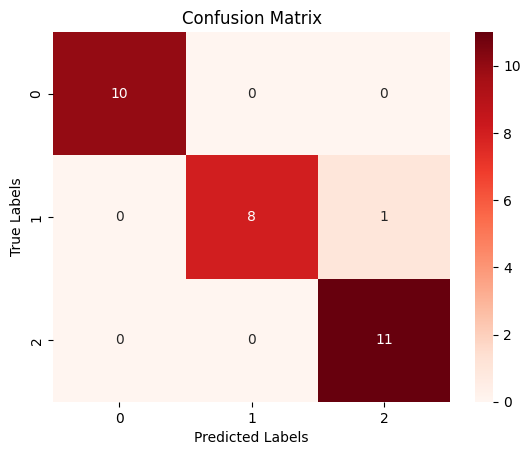

In [260]:
from sklearn.metrics import confusion_matrix

# Get the predicted class labels of the test set using the trained neural network
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="Reds", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

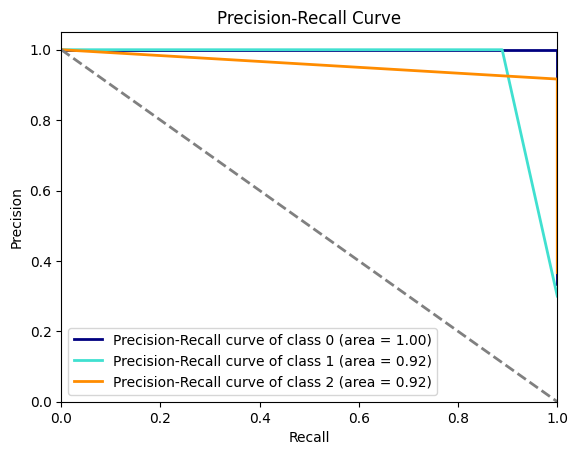

In [261]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


# Convert y_test to binary label indicator matrix using one-vs-all strategy
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

# Compute Precision-Recall curve and area for each class
precision = {}
recall = {}
average_precision = {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_bin[:, i])

# Compute micro-average Precision-Recall curve and area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(),
                                                                y_pred_bin.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_pred_bin,
                                                     average="micro")

# Plot Precision-Recall curve
plt.figure()
lw = 2
colors = ['navy', 'turquoise', 'darkorange']
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color,
             lw=lw, label='Precision-Recall curve of class {0} (area = {1:0.2f})'
             ''.format(i, average_precision[i]))

plt.plot([0, 1], [1, 0], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()